In [1]:
import numpy as np
from ase.io import read
from ase import units
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

In [4]:
traj = read('cu_strc2.traj', index=':')
n_steps = len(traj)
n_atoms = len(traj[0])
dt = 1.0 * units.fs  # timestep in ASE units

In [5]:
#  Collect velocities (shape: n_steps x n_atoms x 3) 
velocities = np.array([atoms.get_velocities() for atoms in traj])  # (steps, atoms, 3)

In [6]:
# Compute Velocity Autocorrelation Function (VACF) 
vacf = np.zeros(n_steps)
for i in range(n_atoms):
    v = velocities[:, i, :]
    v0 = v[0]
    vacf += np.sum(v * v0, axis=1)
vacf /= n_atoms

# Normalize VACF (so VACF[0] = 1)
vacf /= vacf[0]


In [7]:
vdos = np.abs(fft(vacf))
freq = fftfreq(n_steps, dt / units.fs)  # frequency in THz

In [8]:
# Keep only positive frequencies
mask = freq > 0
freq = freq[mask]
vdos = vdos[mask]
vdos /= np.trapz(vdos, freq)  # normalize area to 1

In [9]:
# --- Compute entropy (classical limit) ---
# Classical vibrational entropy per atom (approximation):
# S = k_B * ∫ [1 - ln(hbar*ω / (k_B*T))] * g(ω) dω
T = 300  # temperature in K
hbar = units._hbar  # J*s
kB = units.kB       # J/K

# Avoid division by zero
omega = 2 * np.pi * freq * 1e12  # convert THz to rad/s
g = vdos
mask = omega > 1e10
omega = omega[mask]
g = g[mask]

S_vib = kB * np.trapz((1 - np.log(hbar * omega / (kB * T))) * g, omega)
S_total = S_vib * n_atoms  # total entropy for system (approximate)


In [10]:
print(f"Vibrational entropy per atom ≈ {S_vib/kB:.3f} kB")
print(f"Total entropy ≈ {S_total:.3e} J/K")

Vibrational entropy per atom ≈ 307256261942217.938 kB
Total entropy ≈ 2.860e+12 J/K


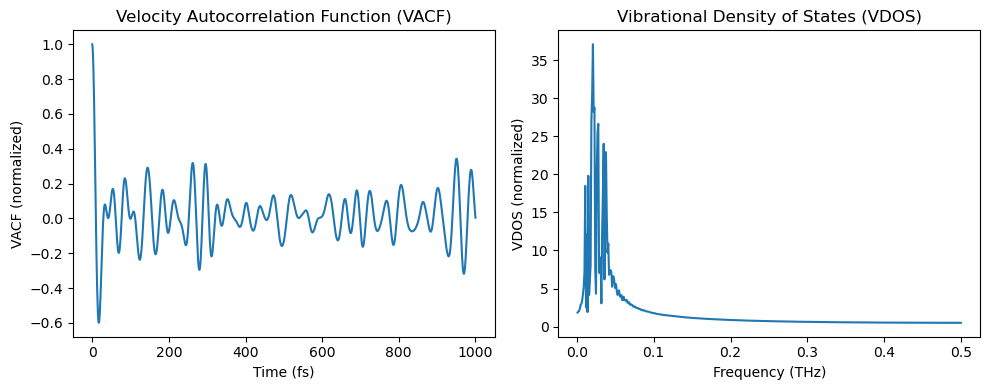

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(np.arange(n_steps)*dt/units.fs, vacf)
plt.title('Velocity Autocorrelation Function (VACF)')
plt.xlabel('Time (fs)')
plt.ylabel('VACF (normalized)')

plt.subplot(1,2,2)
plt.plot(freq, vdos)
plt.title('Vibrational Density of States (VDOS)')
plt.xlabel('Frequency (THz)')
plt.ylabel('VDOS (normalized)')

plt.tight_layout()
plt.show()